<a href="https://colab.research.google.com/github/SRIKARREDDY-dotorg/Hand-Written-hindi-script-recognition/blob/master/FYP_COVID19_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
!pip install kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [37]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/kaggle"

In [38]:
%cd /content/gdrive/My Drive/kaggle

/content/gdrive/My Drive/kaggle


In [39]:
pwd

'/content/gdrive/My Drive/kaggle'

In [ ]:
!kaggle datasets download -d asraf047/covid19-pneumonia-normal-chest-xray-pa-dataset

covid19-pneumonia-normal-chest-xray-pa-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip \*.zip  && rm *.zip

Archive:  covid19-pneumonia-normal-chest-xray-pa-dataset.zip
replace covid/01E392EE-69F9-4E33-BFCE-E5C968654078-768x572.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [40]:

import tensorflow as tf
import gc
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout, GlobalAveragePooling2D, Activation, BatchNormalization, Dropout, LSTM, ConvLSTM2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input,Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation, LSTM, ConvLSTM2D, Lambda, Reshape, BatchNormalization, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint,TensorBoard,TerminateOnNaN, LearningRateScheduler
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TerminateOnNaN
from tensorflow.keras.layers import Lambda, Reshape, DepthwiseConv2D, ZeroPadding2D, Add, MaxPooling2D,Activation, Flatten, Conv2D, Dense, Input, Dropout, Concatenate, GlobalMaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import shutil
import cv2
import os
from datetime import datetime
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [41]:
df = pd.read_csv('/content/gdrive/My Drive/kaggle/metadata.csv')
df_y = df['class']
df_x = df['directory']

In [42]:
df_x

0         covid/COVID19(308).jpg
1       covid/COVID-19 (839).jpg
2       covid/COVID-19 (105).jpg
3       covid/COVID-19 (379).jpg
4         covid/COVID19(443).jpg
                  ...           
4570     normal/00000398_004.png
4571     normal/00000975_000.png
4572     normal/00000766_009.png
4573     normal/00000105_003.png
4574     normal/00000697_001.png
Name: directory, Length: 4575, dtype: object

In [43]:
df_y

0       1
1       1
2       1
3       1
4       1
       ..
4570    0
4571    0
4572    0
4573    0
4574    0
Name: class, Length: 4575, dtype: int64

In [44]:
df_y.value_counts()

2    1525
1    1525
0    1525
Name: class, dtype: int64

In [45]:
X_train, X_test, Y_train, Y_test = train_test_split(df_x, df_y, stratify=df_y, test_size=0.20, random_state=7)

In [46]:
Y_train.value_counts()

1    1220
2    1220
0    1220
Name: class, dtype: int64

In [47]:
Y_test.value_counts()

2    305
1    305
0    305
Name: class, dtype: int64

In [48]:
test = pd.concat([X_test, Y_test], axis = 1)
test.head()

,directory,class
614,covid/COVID-19 (506).jpg,1
2473,pneumonia/person23_bacteria_82.jpeg,2
501,covid/COVID19(241).jpg,1
912,covid/COVID-19 (219).jpg,1
1270,covid/COVID-19 (549).jpg,1


In [ ]:
#@title
def filter_images():
    input_path="/content/gdrive/My Drive/kaggle"
    output_path="/content/gdrive/My Drive/kaggle/Chest_Xray_PA_Dataset"
    if os.path.exists(output_path):
        shutil.rmtree(output_path)
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    classs=['normal','covid','pneumonia']
    for c in classs:
        if not os.path.exists(output_path + '/' + c):
            os.makedirs(output_path + '/' + c)
    for i, row in df.iterrows():
        path_from = "{}/{}".format(input_path, row['directory'])
        print(path_from)
        image=cv2.imread(path_from)
        #print(image)
        #print(1)
        try:
          result=cv2.GaussianBlur(image,(5,5),0)
        except:
          print('hi')
          continue
        #print(image)
        path_to = "{}/{}".format(output_path, row['directory'])
        #print(path_to)
        cv2.imwrite(path_to,result)
filter_images()

In [49]:
#@title
def copy_images(df, directory):
    
    # input and output directory 
    input_path = "/content/gdrive/My Drive/kaggle/Chest_Xray_PA_Dataset"     
    output_path = "/content/gdrive/My Drive/kaggle/dataset/" + directory

    # remove all files from previous fold
    if os.path.exists(output_path):
        shutil.rmtree(output_path)

    # create folder for files from this fold
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    # create subfolders for each class
    classs=['normal','covid','pneumonia']
    for c in classs:
        if not os.path.exists(output_path + '/' + c):
            os.makedirs(output_path + '/' + c)
        
    # copy files
    for i, row in df.iterrows():
        path_from = "{}/{}".format(input_path, row['directory'])
        path_to = "{}/{}".format(output_path, row['directory'])
        shutil.copy(path_from, path_to)

In [50]:
copy_images(test, 'test')

In [51]:
len(os.listdir('/content/gdrive/My Drive/kaggle/dataset/test/covid'))

305

In [52]:
len(os.listdir('/content/gdrive/My Drive/kaggle/dataset/test/normal'))

305

In [53]:
len(os.listdir('/content/gdrive/My Drive/kaggle/dataset/test/pneumonia'))

305

In [54]:
def get_model():
    
    # Input layer
    img_dims=224
    inputs = Input(shape=(img_dims, img_dims, 3))

    # 1st conv block
    x = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', trainable=False, padding='same')(inputs)
    x = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', trainable=False, padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)

    # 2nd conv block
    x = Conv2D(filters=128, kernel_size=(3, 3), activation='relu', trainable=False, padding='same')(x)
    x = Conv2D(filters=128, kernel_size=(3, 3), activation='relu', trainable=False, padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)

    # 3rd conv block
    x = Conv2D(filters=256, kernel_size=(3, 3), activation='relu', trainable=False, padding='same')(x)
    x = Conv2D(filters=256, kernel_size=(3, 3), activation='relu', trainable=False, padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)

    # 4th conv block
    x = Conv2D(filters=512, kernel_size=(3, 3), activation='relu', trainable=False, padding='same')(x)
    x = Conv2D(filters=512, kernel_size=(3, 3), activation='relu', trainable=False, padding='same')(x)
    x = Conv2D(filters=512, kernel_size=(3, 3), activation='relu', trainable=False, padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)

    # 5th conv block
    x = Conv2D(filters=512, kernel_size=(3, 3), activation='relu', trainable=False, padding='same')(x)
    x = Conv2D(filters=512, kernel_size=(3, 3), activation='relu', trainable=False, padding='same')(x)
    x = Conv2D(filters=512, kernel_size=(3, 3), activation='relu', trainable=False, padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
#     x = AveragePooling2D(pool_size=(4, 4))(x)

#     # LSTM layer
#     x = Reshape((49, 512))(x)
#     x = ((LSTM(512, activation="relu", return_sequences=True, trainable=False)))(x)
#     x = BatchNormalization()(x)
#     x = Dropout(0.5)(x)
    
    # FC layer
    x = Flatten(name="flatten")(x)
    x = Dense(units=64, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # Output layer
    output = Dense(units=3, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=output)
    opt = RMSprop(lr=0.0001, decay=1e-6)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=["accuracy"])
    
    return model

In [55]:
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=15, fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [56]:
test_generator = test_datagen.flow_from_directory(
    directory=r"./dataset/test/",
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=1,
    class_mode=None,
    shuffle=False,
    seed=42
)

Found 915 images belonging to 3 classes.


In [57]:
from math import floor
N_FOLDS = 5
EPOCHS = 50
INIT_LR = 3e-4
T_BS = 16
V_BS = 16
decay_rate = 0.95
decay_step = 1

skf = StratifiedKFold(n_splits = 5, random_state = 7, shuffle = True)
log_dir = "./logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

callbacks = [ModelCheckpoint(filepath='best_cnn_model.h5', monitor='val_loss',mode='min',verbose=1,save_best_only=True,save_weights_only=True),
             LearningRateScheduler(lambda epoch : INIT_LR * pow(decay_rate, floor(epoch / decay_step))), tensorboard_callback]

In [58]:
class_to_label_map = {2 : 'pneumonia', 1 : 'covid', 0 : 'normal'}

1    976
2    976
0    976
Name: class, dtype: int64
2    244
1    244
0    244
Name: class, dtype: int64
Running fold 1
Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 224, 224, 64)      36928     
_________________________________________________________________
batch_normalization_6 (Batch (None, 224, 224, 64)      256       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 112, 112, 128)     73856     

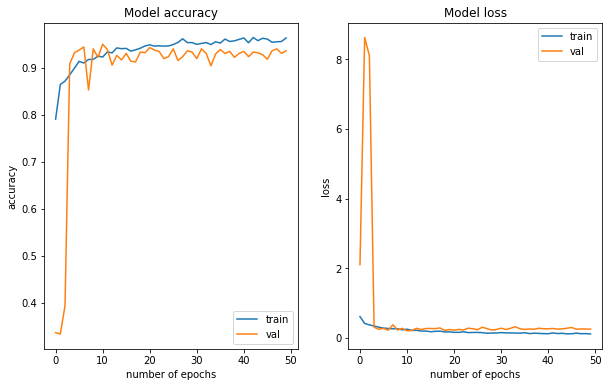

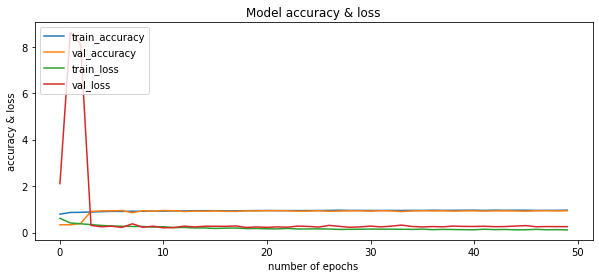

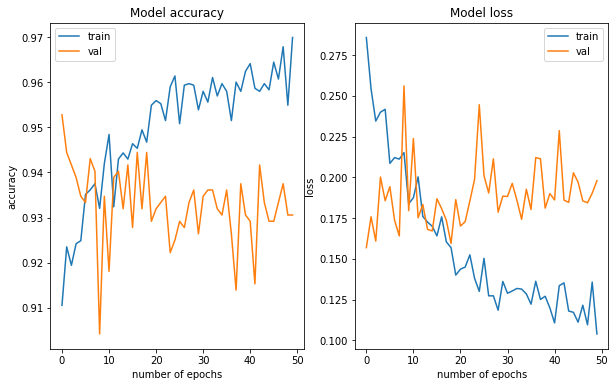

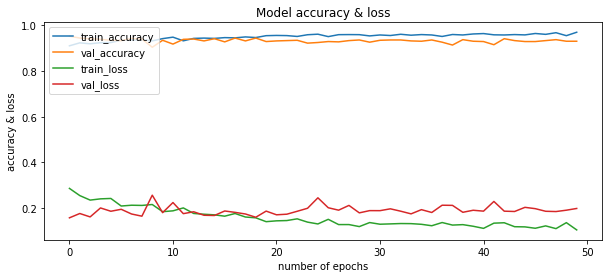

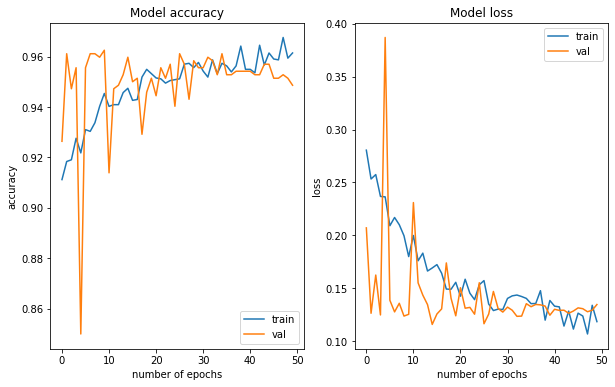

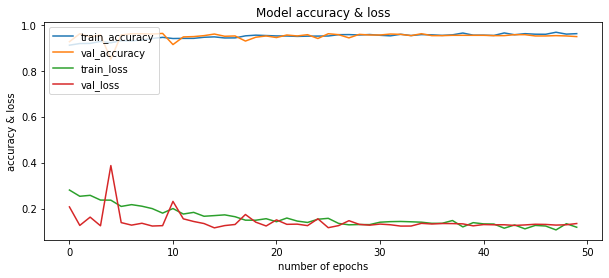

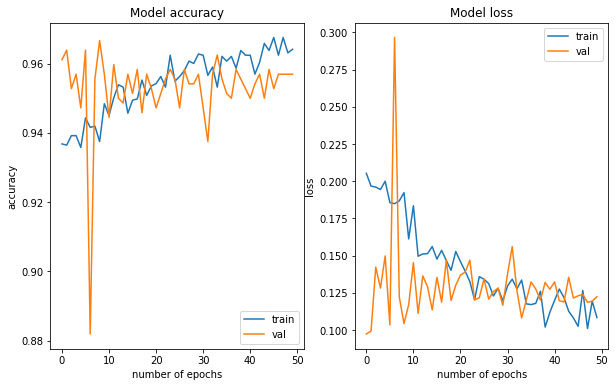

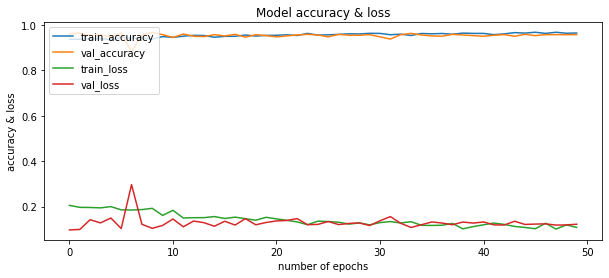

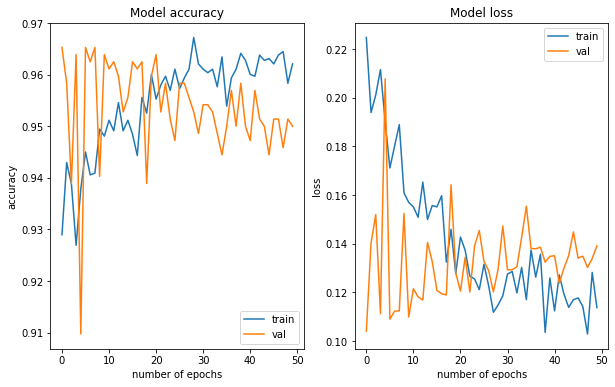

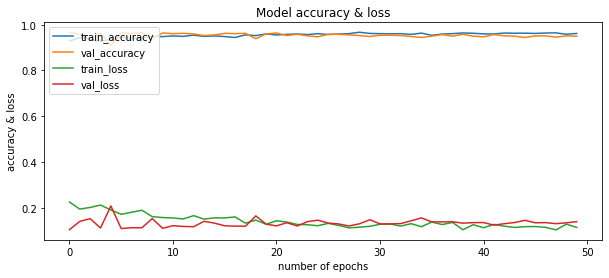

In [59]:
submission_prediction = []
submission_predictions = []

for epoch, (train_index, val_index) in enumerate(skf.split(X_train, Y_train)):
    x_train, x_val = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train, y_val = Y_train.iloc[train_index], Y_train.iloc[val_index]
    
    print(y_train.value_counts())
    print(y_val.value_counts())

    train = pd.concat([x_train, y_train], axis=1)
    val = pd.concat([x_val, y_val], axis = 1)
    
    # copy the images according to the fold
    copy_images(train, 'train')
    copy_images(val, 'val')
    
    print('Running fold '+ str(epoch+1))
    
    # CREATE MODEL
    model = get_model()
    model.summary()
    
    # Load Model Weights
    if epoch != 0:
        model.load_weights('best_cnn_model.h5') 
    
    train_generator = train_datagen.flow_from_directory(
        directory=r"./dataset/train/",
        target_size=(224, 224),
        color_mode="rgb",
        batch_size=16,
        class_mode="categorical",
        shuffle=True,
        seed=42
    )
    valid_generator = val_datagen.flow_from_directory(
        directory=r"./dataset/val/",
        target_size=(224, 224),
        color_mode="rgb",
        batch_size=16,
        class_mode="categorical",
        shuffle=True,
        seed=42
    )
    
    history = model.fit_generator(
                generator=train_generator,
                steps_per_epoch=train_generator.n//train_generator.batch_size,
                validation_data=valid_generator,
                validation_steps=valid_generator.n//valid_generator.batch_size,
                epochs=EPOCHS,
                callbacks=callbacks
    )
    
    hist_df = pd.DataFrame(history.history) 
    hist_csv_file = 'history.csv'
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 6))
    ax = ax.ravel()
    for i, met in enumerate(['accuracy', 'loss']):
        ax[i].plot(history.history[met])
        ax[i].plot(history.history['val_' + met])
        ax[i].set_title('Model {}'.format(met))
        ax[i].set_xlabel('number of epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['train', 'val'])
    plt.savefig('accuracy_performance_graph'+'_'+str(epoch)+'.png')
    
    test_generator.reset()
    predY=model.predict_generator(
            test_generator,
            steps=test_generator.n//test_generator.batch_size,
            verbose=1)
    submission_prediction.append(predY)

    if epoch >= 1:
        submission_predictions.append(predY)
        
    testY = test_generator.classes
    confusion__matrix=confusion_matrix(testY, np.argmax(predY, axis = -1))
    cr=(classification_report(testY, np.argmax(predY, axis = -1), target_names=class_to_label_map, output_dict=True))
    print (cr)
    print(confusion__matrix)
    
    cm_df = pd.DataFrame(confusion__matrix)
    cr_df = pd.DataFrame(cr)
    with open(hist_csv_file, mode='a') as f:
        hist_df.to_csv(f)
        cm_df.to_csv(f)
        cr_df.to_csv(f)
    
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['accuracy'], label='train_accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title("Model accuracy & loss")
    plt.ylabel("accuracy & loss")
    plt.xlabel("number of epochs")
    plt.legend(["train_accuracy", "val_accuracy", "train_loss", "val_loss"], loc="upper left")
    plt.savefig('accuracy_loss_performance'+'_'+str(epoch)+'.png')
    
    model.save('final_cnn_model.h5') 
    
    del history
    del model
    gc.collect()

In [60]:
len(os.listdir('./dataset/train/normal'))

976

In [61]:
len(os.listdir('./dataset/val/normal'))

244

In [62]:
predY = np.average(submission_predictions, axis = 0, weights = [2**i for i in range(len(submission_predictions))])

In [63]:
testY = test_generator.classes

In [64]:
roc_auc_score(testY, predY, multi_class='ovo')

0.9844181671593657

In [65]:
roc_auc_score(testY, predY, multi_class='ovr')

0.9844181671593658

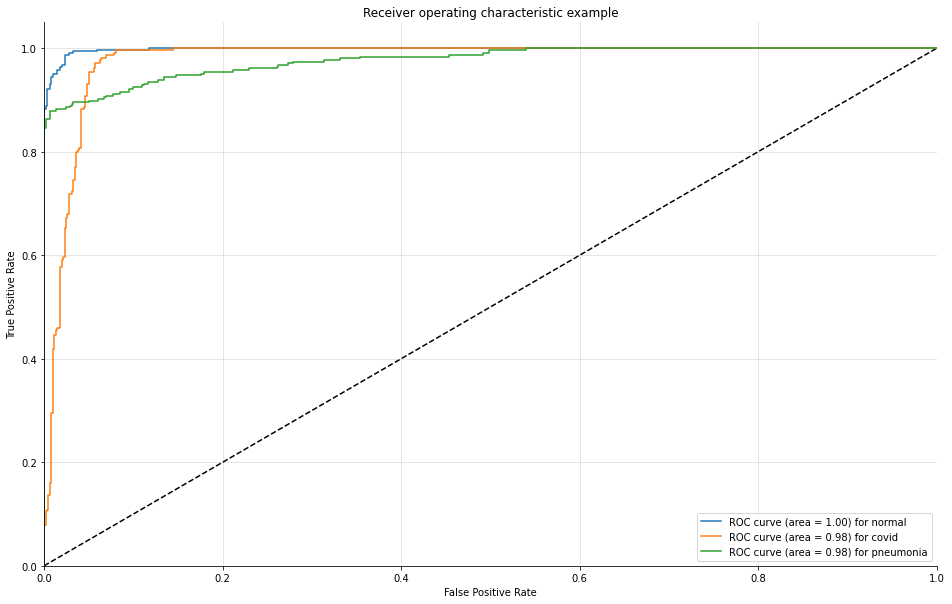

In [66]:
import seaborn as sns
def plot_multiclass_roc(y_test, y_score, n_classes, figsize=(17, 6)):

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for %s' % (roc_auc[i], class_to_label_map[i]))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

plot_multiclass_roc(testY, predY, n_classes=3, figsize=(16, 10))

In [67]:
cm_mat = confusion_matrix(testY, np.argmax(predY, axis = -1))

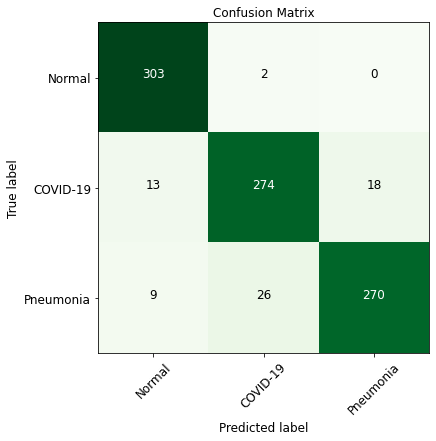

In [68]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Greens')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize = 'larger')

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45, fontsize = 'larger')
        plt.yticks(tick_marks, target_names, fontsize = 'larger')

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black", fontsize = 'larger')
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black", fontsize = 'larger')


    plt.tight_layout()
    plt.ylabel('True label', fontsize = 'larger')
    plt.xlabel('Predicted label', fontsize = 'larger')
#     plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    
plot_confusion_matrix(cm_mat, 
                      normalize = False,
                      target_names = ['Normal', 'COVID-19', 'Pneumonia'],
                      title        = "Confusion Matrix")


In [69]:
print(classification_report(testY, np.argmax(predY, axis = -1), target_names = ['normal', 'covid', 'pneumonia']))

              precision    recall  f1-score   support

      normal       0.93      0.99      0.96       305
       covid       0.91      0.90      0.90       305
   pneumonia       0.94      0.89      0.91       305

    accuracy                           0.93       915
   macro avg       0.93      0.93      0.93       915
weighted avg       0.93      0.93      0.93       915

